In [1]:
from scipy.io import loadmat
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

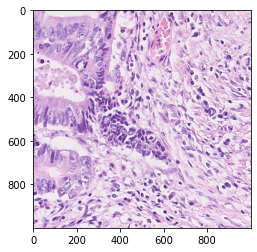

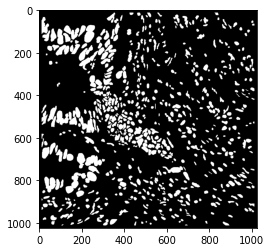

In [2]:
############################################
# Display Image and its corresponding Mask #
############################################
x = loadmat('./Train/Labels/train_1.mat')
img=mpimg.imread('./Train/Images/train_1.png')
imgplot = plt.imshow(img)
plt.show()
imshow(np.pad((x['inst_map']>=1).astype(int),12),cmap='gray')

In [3]:
class NucleiDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.img_ls = [image_path+i for i in sorted(os.listdir(image_path))]
        self.mask_ls = [ mask_path+i for i in sorted(os.listdir(mask_path))]
        self.transform = transform

    def __len__(self):
        return len(self.img_ls)

    def __getitem__(self, idx):
        img_name = self.img_ls[idx]
        img = Image.open(img_name).convert('RGB')
        img.load()
        mask_name = self.mask_ls[idx]
        mask = np.pad((loadmat(mask_name)['inst_map']>=1).astype(int),12)  
        if self.transform:
            img = self.transform(img)

        return img, mask


trans = transforms.Compose([
    transforms.Pad(12),    # given image is 1000x1000, pad it to make it 1024x1024
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet normalization
])

label_path = "./Train/Labels/"
img_path = "./Train/Images/"

train_set = NucleiDataset(img_path,label_path, transform = trans)

batch_size = 1  #my gpu is 8gb, using batchsize of 2 already insufficient memory, so i use batch size 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1024, 1024])


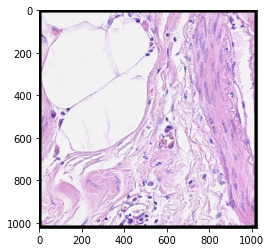

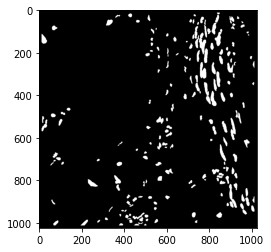

In [4]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp


inputs, masks = next(iter(train_loader))

print(inputs.shape, masks.shape)  #shapes of our inputs to the model and loss function

plt.imshow(reverse_transform(inputs[0]))
plt.show()
imshow(masks[0],cmap='gray')

In [5]:
######################
# Model Architecture #
######################

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [6]:
###################################################################
# Loss function that combines Binary Cross Entropy with Dice loss #
###################################################################

# Model output is (N, 1, 1024,1024), where N = batch size, Thus you will see that i squeeze the 2nd dimension

def weighted_loss(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss

In [7]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    loss_ls = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()
        
        loss = 0
        
        for inputs,masks in train_loader:
            model.train()
            inputs = inputs.to(device)
            masks = masks.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            epoch_loss = weighted_loss(outputs,masks,bce_weight=0.3)
            epoch_loss.backward()
            optimizer.step()
            
            n_samples = len(inputs)
            loss+=(epoch_loss/n_samples).item()
        
        loss /= len(train_loader)
        print("epoch loss:",loss)
        loss_ls.append(loss)
        
        if (epoch+1)%5==0:
            print("\n","Input Image")
            plt.imshow(reverse_transform(inputs.to('cpu').detach()[0]))
            plt.show()
            print("Predicted Mask Sigmoid")
            plt.imshow(outputs.to('cpu').detach().numpy()[0][0],cmap='gray')
            plt.show()
            print("Actual Mask")
            plt.imshow(masks.to('cpu').detach()[0],cmap='gray')
            plt.show()
        
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),"\n")
    
    return loss_ls

cuda:0
Epoch 0/59
----------
epoch loss: 0.694212798719053
0m 15s 

Epoch 1/59
----------
epoch loss: 0.5820094214545356
0m 15s 

Epoch 2/59
----------
epoch loss: 0.4197367352467996
0m 16s 

Epoch 3/59
----------
epoch loss: 0.3360236160181187
0m 16s 

Epoch 4/59
----------
epoch loss: 0.30822235842545825

 Input Image


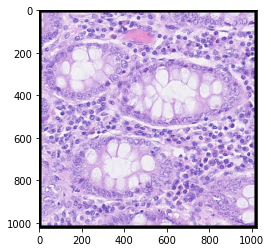

Predicted Mask Sigmoid


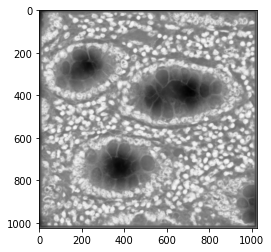

Actual Mask


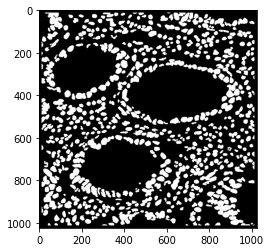

0m 16s 

Epoch 5/59
----------
epoch loss: 0.2749618772003386
0m 16s 

Epoch 6/59
----------
epoch loss: 0.2523061721413224
0m 16s 

Epoch 7/59
----------
epoch loss: 0.23441404435369703
0m 17s 

Epoch 8/59
----------
epoch loss: 0.22533461120393541
0m 16s 

Epoch 9/59
----------
epoch loss: 0.21146778155256202

 Input Image


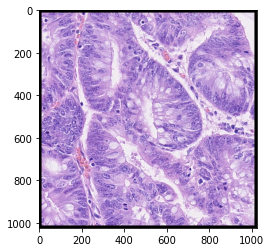

Predicted Mask Sigmoid


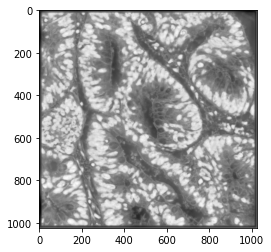

Actual Mask


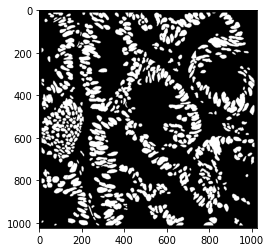

0m 17s 

Epoch 10/59
----------
epoch loss: 0.20638591658186028
0m 16s 

Epoch 11/59
----------
epoch loss: 0.21467502994669807
0m 16s 

Epoch 12/59
----------
epoch loss: 0.20427262507103108
0m 16s 

Epoch 13/59
----------
epoch loss: 0.19841484753070054
0m 16s 

Epoch 14/59
----------
epoch loss: 0.19967039095030892

 Input Image


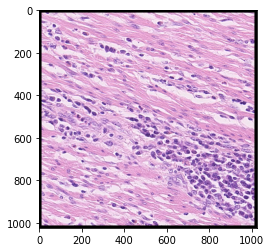

Predicted Mask Sigmoid


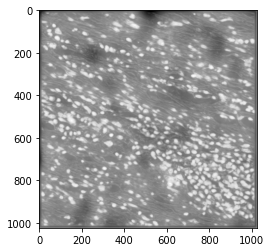

Actual Mask


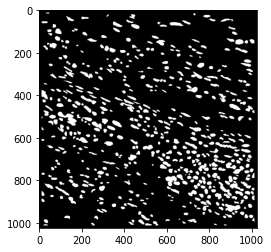

0m 17s 

Epoch 15/59
----------
epoch loss: 0.1953003900470557
0m 18s 

Epoch 16/59
----------
epoch loss: 0.19193344204514115
0m 17s 

Epoch 17/59
----------
epoch loss: 0.186255338843222
0m 17s 

Epoch 18/59
----------
epoch loss: 0.1793262861945011
0m 18s 

Epoch 19/59
----------
epoch loss: 0.17525149605892323

 Input Image


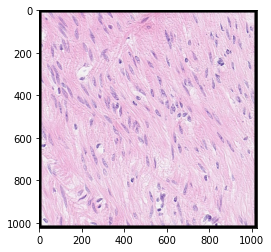

Predicted Mask Sigmoid


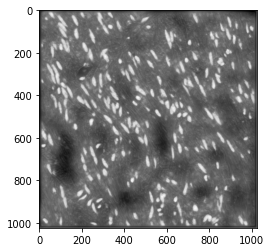

Actual Mask


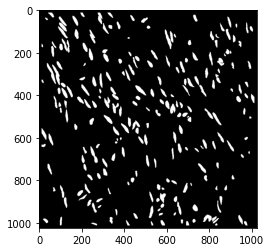

0m 18s 

Epoch 20/59
----------
epoch loss: 0.18009268299297052
0m 18s 

Epoch 21/59
----------
epoch loss: 0.19553989309955527
0m 17s 

Epoch 22/59
----------
epoch loss: 0.18760687250781943
0m 17s 

Epoch 23/59
----------
epoch loss: 0.1815174917380015
0m 18s 

Epoch 24/59
----------
epoch loss: 0.17176922879837178

 Input Image


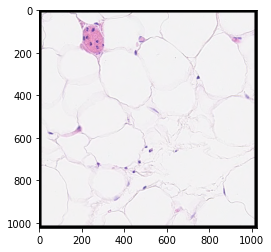

Predicted Mask Sigmoid


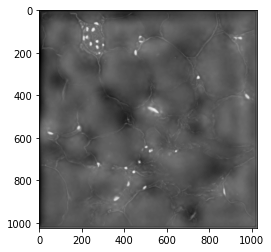

Actual Mask


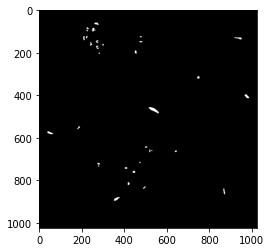

0m 18s 

Epoch 25/59
----------
epoch loss: 0.16670453879568312
0m 17s 

Epoch 26/59
----------
epoch loss: 0.16292011185928626
0m 17s 

Epoch 27/59
----------
epoch loss: 0.1622543348758309
0m 17s 

Epoch 28/59
----------
epoch loss: 0.1639155030802444
0m 17s 

Epoch 29/59
----------
epoch loss: 0.16637000579524924

 Input Image


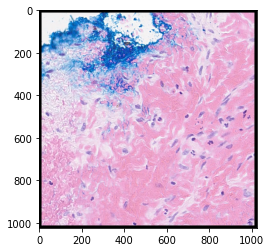

Predicted Mask Sigmoid


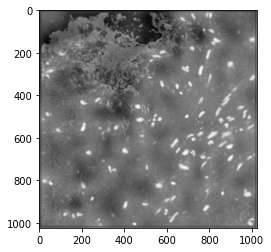

Actual Mask


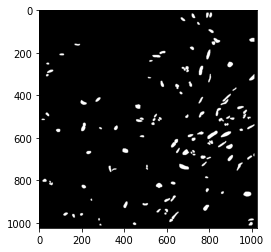

0m 18s 

Epoch 30/59
----------
epoch loss: 0.16464223712682724
0m 17s 

Epoch 31/59
----------
epoch loss: 0.16097818480597603
0m 18s 

Epoch 32/59
----------
epoch loss: 0.15763204710351097
0m 17s 

Epoch 33/59
----------
epoch loss: 0.15616253045973955
0m 17s 

Epoch 34/59
----------
epoch loss: 0.15553480524707725

 Input Image


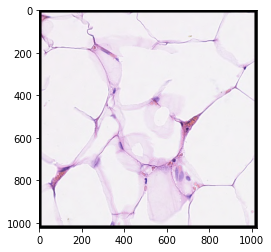

Predicted Mask Sigmoid


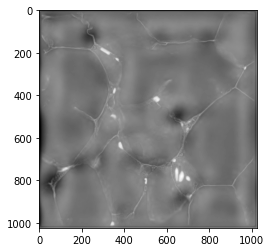

Actual Mask


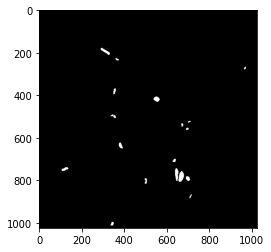

0m 18s 

Epoch 35/59
----------
epoch loss: 0.14887755226205895
0m 17s 

Epoch 36/59
----------
epoch loss: 0.1461876087166645
0m 17s 

Epoch 37/59
----------
epoch loss: 0.14348935004737642
0m 17s 

Epoch 38/59
----------
epoch loss: 0.14023054929243195
0m 17s 

Epoch 39/59
----------
epoch loss: 0.1420252018228725

 Input Image


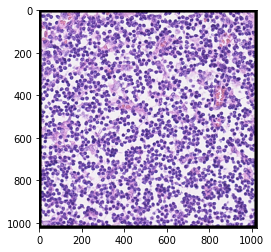

Predicted Mask Sigmoid


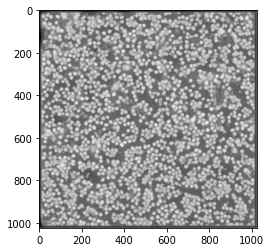

Actual Mask


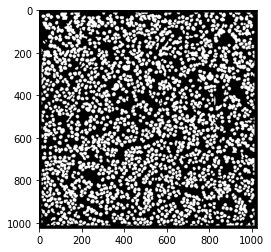

0m 17s 

Epoch 40/59
----------
epoch loss: 0.1403382703385971
0m 17s 

Epoch 41/59
----------
epoch loss: 0.1378579799223829
0m 17s 

Epoch 42/59
----------
epoch loss: 0.13855170417163107
0m 18s 

Epoch 43/59
----------
epoch loss: 0.13584451473973416
0m 18s 

Epoch 44/59
----------
epoch loss: 0.13628083508875635

 Input Image


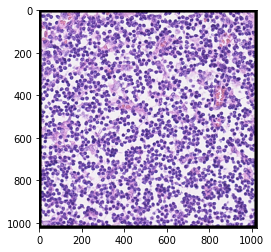

Predicted Mask Sigmoid


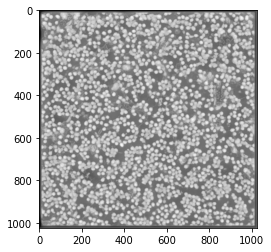

Actual Mask


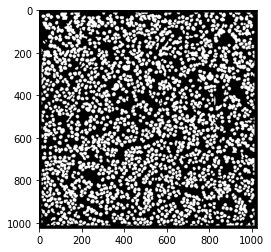

0m 18s 

Epoch 45/59
----------
epoch loss: 0.1374667259278121
0m 17s 

Epoch 46/59
----------
epoch loss: 0.1388877812359068
0m 17s 

Epoch 47/59
----------
epoch loss: 0.13053232790143401
0m 17s 

Epoch 48/59
----------
epoch loss: 0.12518399802071076
0m 17s 

Epoch 49/59
----------
epoch loss: 0.12432812016319346

 Input Image


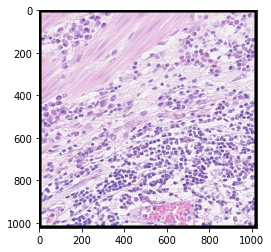

Predicted Mask Sigmoid


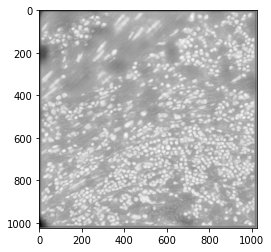

Actual Mask


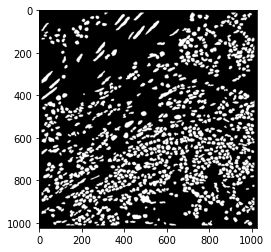

0m 18s 

Epoch 50/59
----------
epoch loss: 0.12532796931487541
0m 17s 

Epoch 51/59
----------
epoch loss: 0.12359011449195721
0m 16s 

Epoch 52/59
----------
epoch loss: 0.12013887889959195
0m 17s 

Epoch 53/59
----------
epoch loss: 0.12014431078676824
0m 17s 

Epoch 54/59
----------
epoch loss: 0.1237319069052184

 Input Image


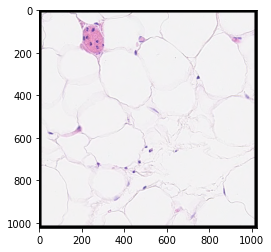

Predicted Mask Sigmoid


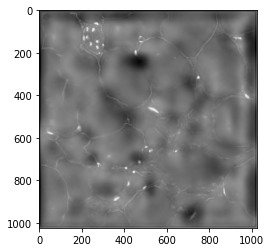

Actual Mask


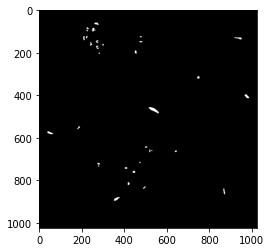

0m 17s 

Epoch 55/59
----------
epoch loss: 0.1503097668842033
0m 16s 

Epoch 56/59
----------
epoch loss: 0.14933338595761192
0m 17s 

Epoch 57/59
----------
epoch loss: 0.13792892614448513
0m 18s 

Epoch 58/59
----------
epoch loss: 0.14281421154737473
0m 17s 

Epoch 59/59
----------
epoch loss: 0.12618369567725393

 Input Image


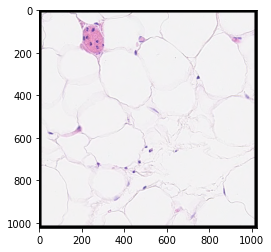

Predicted Mask Sigmoid


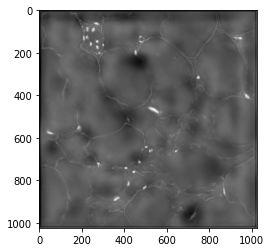

Actual Mask


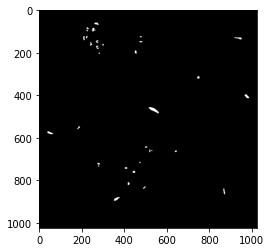

0m 17s 



In [8]:
#################
# Training Loop #
#################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1
model = ResNetUNet(num_class).to(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

loss_ls = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

In [9]:
# torch.save(model.state_dict(), "./weights1")

In [10]:
#################################
# Load model with saved weights #
#################################

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = ResNetUNet(1)
# model.load_state_dict(torch.load("./weights1"))
# model.to(device)

In [11]:
#######################
# Test Set Dataloader #
#######################

label_path = "./Test/Labels/"
img_path = "./Test/Images/"

test_set = NucleiDataset(img_path,label_path, transform = trans)

batch_size = 1

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1)

Input Image


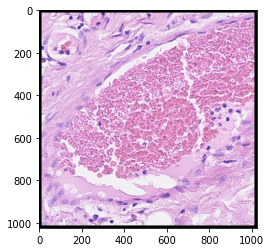

Predicted Mask Sigmoid


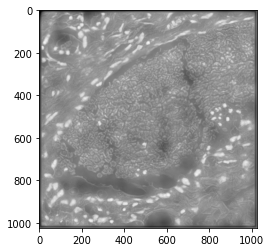

Predicted Mask Binary


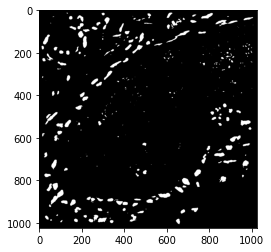

Actual Mask


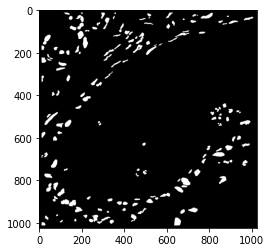

In [12]:
inputs, masks = next(iter(test_loader))
print("Input Image")
plt.imshow(reverse_transform(inputs[0]))
plt.show()
outputs = model(inputs.to(device))
pred = outputs.to('cpu').detach().numpy()[0][0]

print("Predicted Mask Sigmoid")
plt.imshow(pred,cmap='gray')
plt.show()
threshold=0.95     # vary the threshold
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
print("Predicted Mask Binary")
plt.imshow(pred,cmap='gray')
plt.show()
print("Actual Mask")
plt.imshow(masks[0],cmap='gray')
plt.show()